In [33]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_fid import fid_score
from torchvision.utils import save_image
import torch.nn.functional as F
import torchvision.utils as vutils
import random

# Butterfly Dataset

In [34]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_filepath=r"/home/vishnuja/archive/Training_set.csv" 

data_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor() ,
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

dataset = load_dataset('csv', data_files=dataset_filepath)


# Function transform the image
def transform_image(data):
    image = Image.open('/home/vishnuja/archive/train/'+data['filename'])
    data['image'] = data_transforms(image)
    return data

dataset = dataset.map(transform_image)
dataset.set_format(type='torch', columns=['image'])

dataloader_butterfly = DataLoader(dataset['train'], batch_size=128, shuffle=True, num_workers=5)



In [35]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [76]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_filepath=r"/home/vishnuja/animals-20240919T032136Z-001/animals/animals" 

data_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor() ,
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

dataset = datasets.ImageFolder(root=dataset_filepath, transform=data_transforms)
print(dataset.classes) 
print(dataset.class_to_idx) 

img, label = dataset[5399 ]
print(img.shape, label) 

dataloader_animals = DataLoader(dataset, batch_size=128, shuffle=True,num_workers=5)

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']
{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison

# FID Calculation

In [60]:

def calculate_fid_butterfly(netG,params):
    real_idx = 0
    gen_idx = 0
    eps = 1e-10 
    resize_transform = transforms.Compose([
        transforms.Resize((299, 299)) 
    ])
        
    real_img_dir = 'real_images_butterfly'
    gen_img_dir = 'generated_images_butterfly'
    os.makedirs(real_img_dir, exist_ok=True)
    os.makedirs(gen_img_dir, exist_ok=True)

    def save_images(images, directory, prefix, start_idx):
        os.makedirs(directory, exist_ok=True)
        for i, img in enumerate(images):
            save_image(img, os.path.join(directory, f"{prefix}_{start_idx + i}.png"))

    for data in dataloader_butterfly:
        real_images = data['image'].to(device).cpu()
        if real_idx < 1000:  # Limit to 1000 images
            for idx, img in enumerate(real_images): 
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val + eps)
                resized_img = resize_transform(normalized_img)
                save_images(resized_img, real_img_dir, "real", real_idx+idx)
                    
            real_idx += real_images.shape[0]
        if gen_idx < 1000:
            z = torch.randn(real_images.shape[0], params['dim_z'], 1, 1, device=device)
            generated_imgs = netG(z).cpu()
                    
            for idx, img in enumerate(generated_imgs):
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val + eps)
                resized_img = resize_transform(normalized_img)
                save_images(resized_img, gen_img_dir, "gen", gen_idx+idx)
            gen_idx += real_images.shape[0]


    # Compute FID
    fid_value = fid_score.calculate_fid_given_paths([real_img_dir, gen_img_dir], batch_size=64, device=device, dims=2048)
    return fid_value

In [59]:

def calculate_fid_animals(netG,params):
    real_idx = 0
    gen_idx = 0
    eps = 1e-10  
    resize_transform = transforms.Compose([
        transforms.Resize((299, 299)) 
    ])
        
    real_img_dir = 'real_images_animals'
    gen_img_dir = 'generated_images_animals'
    os.makedirs(real_img_dir, exist_ok=True)
    os.makedirs(gen_img_dir, exist_ok=True)

    def save_images(images, directory, prefix, start_idx):
        os.makedirs(directory, exist_ok=True)
        for i, img in enumerate(images):
            save_image(img, os.path.join(directory, f"{prefix}_{start_idx + i}.png"))

    for image,_ in dataloader_animals:
        real_images = image.to(device).cpu()
        if real_idx < 1000:  
            for idx, img in enumerate(real_images): 
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val + eps)
                resized_img = resize_transform(normalized_img)
                save_images(resized_img, real_img_dir, "real", real_idx+idx)
                    
            real_idx += real_images.shape[0]
        if gen_idx < 1000:
            z = torch.randn(real_images.shape[0], params['dim_z'], 1, 1, device=device)
            generated_imgs = netG(z).cpu()
                    
            for idx, img in enumerate(generated_imgs):
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val + eps)
                resized_img = resize_transform(normalized_img)
                save_images(resized_img, gen_img_dir, "gen", gen_idx+idx)
            gen_idx += real_images.shape[0]


    # Compute FID
    fid_value = fid_score.calculate_fid_given_paths([real_img_dir, gen_img_dir], batch_size=64, device=device, dims=2048)
    return fid_value

# DCGAN 

In [39]:

def weights_init(w):
    classname = w.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

# Generator 
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.conv_transpose1 = nn.ConvTranspose2d(params['dim_z'], 128*16, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(128*16)
        
        self.conv_transpose2 = nn.ConvTranspose2d(128*16, 128*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128*8)
        
        self.conv_transpose3 = nn.ConvTranspose2d(128*8, 128*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128*4)

        self.conv_transpose4 = nn.ConvTranspose2d(128*4, 128*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128*2)

        self.conv_transpose5 = nn.ConvTranspose2d(128*2, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv_transpose6 = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv_transpose1(x)))
        x = F.relu(self.bn2(self.conv_transpose2(x)))
        x = F.relu(self.bn3(self.conv_transpose3(x)))
        x = F.relu(self.bn4(self.conv_transpose4(x)))
        x = F.relu(self.bn5(self.conv_transpose5(x)))

        x = F.tanh(self.conv_transpose6(x))

        return x

# Discriminator 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False)

        self.conv2 = nn.Conv2d(128, 128*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128*2)

        self.conv3 = nn.Conv2d(128*2, 128*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128*4)

        self.conv4 = nn.Conv2d(128*4, 128*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128*8)

        self.conv5 = nn.Conv2d(128*8, 1, kernel_size=4, stride=1, padding=0, bias=False)
        
        self.linear1 = nn.Sequential(
            nn.Linear(1*5*5,1 ),
            nn.Sigmoid()               
        )

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = self.conv5(x)
        x = x.view(x.shape[0],-1)
        x = self.linear1(x)

        return x

#### Architecture Used (dim_z = 100)

Generator(

  (conv_transpose1): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
  
  (bn1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (conv_transpose2): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

  (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (conv_transpose3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (conv_transpose4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (conv_transpose5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (conv_transpose6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

)

Discriminator(

  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)

  (linear1): Sequential(
    (0): Linear(in_features=25, out_features=1, bias=True)
    (1): Sigmoid()
  )
  
)


### Butterfly Dataset

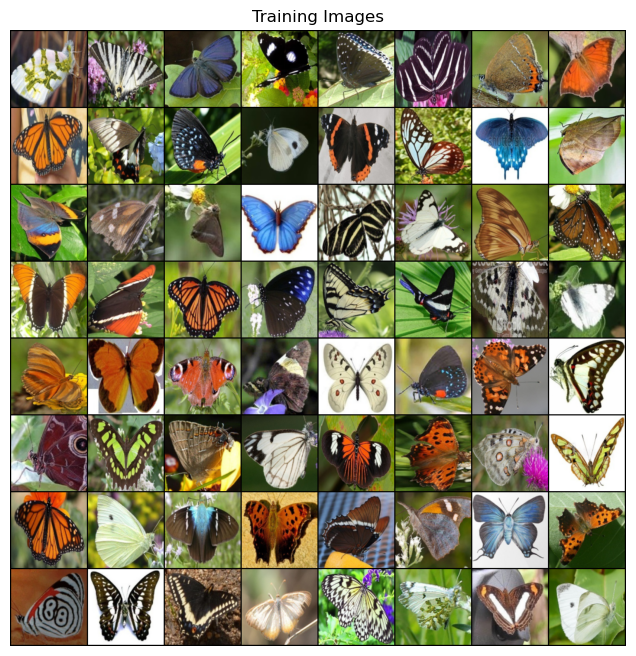

Generator(
  (conv_transpose1): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose2): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [113]:


# HyperParameters
params = {
    'dim_z' : 100,
    'num_epochs' : 300,
    'lr' : 0.0002,
    'save_epoch' : 10,
    'k_d':1,
    'k_g':1}

# Plot the training images.
data = next(iter(dataloader_butterfly))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
    data['image'].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

# Generator
netG = Generator(params).to(device)
netG.apply(weights_init)
print(netG)

# Discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# Loss function.
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(0.5, 0.999))

G_losses = []
D_losses = []
